# Future projections of global hail hazard

In [1]:
%cd git/future_hail_global/

/home/561/tr2908/git/future_hail_global


In [2]:
import sys
sys.path.append('../xarray_parcel/')
sys.path.append('../aus400_hail/')
sys.path.append('../warming_levels/')
                
import dask
import xarray
import warnings
import numpy as np
import itertools
import pandas as pd
import seaborn as sns
from clef.code import *
import cartopy.crs as ccrs
from importlib import reload
import modules.fut_hail as fh
import matplotlib.pyplot as plt
import modules.warming_levels as wl
from dask.distributed import Client, Scheduler, LocalCluster

## Setup

In [3]:
_ = dask.config.set(**{'array.slicing.split_large_chunks': False})
client = Client()
print(client)

<Client: 'tcp://127.0.0.1:46005' processes=7 threads=28, memory=126.00 GiB>


## Settings

In [27]:
plt.show()                                        # Start the plotting engine.
plt.rcParams['font.size'] = 16                    # Font size for plots.
plt.rcParams['axes.formatter.useoffset'] = False  # Don't use offsets in plots.

## Model selection

Find models matching criteria. The following criteria are used to select models:

* Must contain variables:
     - `tas`, temperature at surface
     - `ta`, temperature by level
     - `uas`, u wind at surface
     - `ua`, u wind by level
     - `vas`, v wind at surface
     - `va`, v wind by level
     - `huss`, specific humidity at surface
     - `hus`, specific humidity by level
     - `ps`, surface pressure
* Must be available with a table ID of `3hr` or `6hrLev` (six hour minimum temporal resolution).
* Must include both `historical` and `ssp585` experiments.
* Must be available locally on NCI.

In [5]:
models = fh.select_all_models()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use D

In [6]:
models

,model,ensemble,exp,institution_id,desc,CMIP6_dir
0,BCC-CSM2-MR,r1i1p1f1,historical,BCC,CMIP6.CMIP.BCC.BCC-CSM2-MR.historical.r1i1p1f1,/g/data/oi10/replicas
1,BCC-CSM2-MR,r1i1p1f1,ssp585,BCC,CMIP6.ScenarioMIP.BCC.BCC-CSM2-MR.ssp585.r1i1p1f1,/g/data/oi10/replicas
2,CMCC-CM2-SR5,r1i1p1f1,historical,CMCC,CMIP6.CMIP.CMCC.CMCC-CM2-SR5.historical.r1i1p1f1,/g/data/oi10/replicas
3,CMCC-CM2-SR5,r1i1p1f1,ssp585,CMCC,CMIP6.ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp585.r1i...,/g/data/oi10/replicas
4,CMCC-ESM2,r1i1p1f1,historical,CMCC,CMIP6.CMIP.CMCC.CMCC-ESM2.historical.r1i1p1f1,/g/data/oi10/replicas
5,CMCC-ESM2,r1i1p1f1,ssp585,CMCC,CMIP6.ScenarioMIP.CMCC.CMCC-ESM2.ssp585.r1i1p1f1,/g/data/oi10/replicas
6,CNRM-CM6-1,r1i1p1f2,historical,CNRM-CERFACS,CMIP6.CMIP.CNRM-CERFACS.CNRM-CM6-1.historical....,/g/data/oi10/replicas
7,CNRM-CM6-1,r1i1p1f2,ssp585,CNRM-CERFACS,CMIP6.ScenarioMIP.CNRM-CERFACS.CNRM-CM6-1.ssp5...,/g/data/oi10/replicas
8,EC-Earth3,r1i1p1f1,historical,EC-Earth-Consortium,CMIP6.CMIP.EC-Earth-Consortium.EC-Earth3.histo...,/g/data/oi10/replicas
9,EC-Earth3,r1i1p1f1,ssp585,EC-Earth-Consortium,CMIP6.ScenarioMIP.EC-Earth-Consortium.EC-Earth...,/g/data/oi10/replicas


Now that models are selected, define runs over 20 year periods. We filter out models that
- do not cover the required times or
- are not available on pressure levels.

In [19]:
runs = fh.define_runs(models=models)

ACCESS-CM2 historical is not on pressure levels. Excluding ACCESS-CM2.
BCC-CSM2-MR historical requires 1980-1999, but data for va covers only 2012-2014. Excluding BCC-CSM2-MR.


In [20]:
runs[['model', 'ensemble', 'exp', 'start_year', 'end_year']]

,model,ensemble,exp,start_year,end_year
0,CMCC-CM2-SR5,r1i1p1f1,historical,1980,1999
1,CMCC-ESM2,r1i1p1f1,historical,1980,1999
2,CNRM-CM6-1,r1i1p1f2,historical,1980,1999
3,EC-Earth3,r1i1p1f1,historical,1980,1999
4,GISS-E2-1-G,r1i1p1f2,historical,1980,1999
5,MIROC6,r1i1p1f1,historical,1980,1999
6,MPI-ESM1-2-HR,r1i1p1f1,historical,1980,1999
7,MRI-ESM2-0,r1i1p1f1,historical,1980,1999
8,CMCC-CM2-SR5,r1i1p1f1,ssp585 (2C),2037,2056
9,CMCC-ESM2,r1i1p1f1,ssp585 (2C),2041,2060


If `orog` is available for surface elevation it is used. Some models are missing it, however, and if missing, orography from CNRM-CM6-1/historical/r1i1p1f2 is interpolated to the same grid and used. This code produce the backup orography per model with missing orography. It will not regenerate already-generated files. Note that the use of xemsf gridding routines seems to crash dask processes run using MPI on gadi, so this regridding has to be done "offline" here.

In [21]:
fh.make_backup_orography(runs)

In [22]:
runs.to_csv('results/runs_list.csv', index=False)

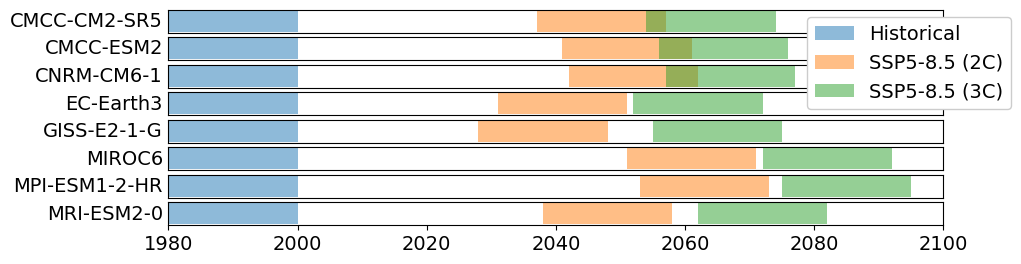

In [23]:
fh.plot_run_years(runs, file='results/run_years.pdf')

Note that grid information is missing from some files for MRI, CMCC, and MPI. The missing information is (as of 19.05.2023):

```
MRI: grid-spec gn, orog version gn/v20190603
CMCC: grid-spec gn, orog version gn/v20210126
MPI: grid-spec gn, orog version gn/v20190710
```

## Process CMIP6 data

Scripts are generated for each model/experiment, under
    
```
scripts/{model_name}/process_CMIP_{model_name}_{experiment}-1.sh
scripts/{model_name}/process_CMIP_{model_name}_{experiment}-2.sh
```

The first processes the first 10 years, the second the last 10 years.

Uncomment the following block to (re)create all scripts for generating convective indices for each run. 

In [ ]:
# fh.make_run_scripts(runs=runs)

Post-processing into annual/seasonal statistics is done by writing the epochs to process to a CSV file:

In [ ]:
# fh.make_postprocessing_scripts(runs=runs)

and then ensuring the job IDs match the number of epochs and running the script

```
post_process_CMIP.sh
```

in each run subdirectory.

## Read processed data

In [57]:
dat = fh.read_processed_data()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 15.61 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


The land mask is the ERA5 land mask set to lsm > 0, to allow all but the largest interior water areas e.g. lakes to be included.

In [7]:
landmask = fh.gen_land_mask(out_dat=dat).load()

NameError: name 'dat' is not defined

In [59]:
dat = dat.where(landmask.lsm == True)

In [ ]:
cmip6_mean = dat.annual_hail_proxy.mean(['model', 'year_num']).sel(epoch='historical').load()
era5_mean = fh.era5_climatology().annual_mean_hail_proxy.where(landmask.lsm == True).load()

In [ ]:
cmip6_mean_noconds = dat.annual_hail_proxy_noconds.mean(['model', 'year_num']).sel(epoch='historical').load()
era5_mean_noconds = fh.era5_climatology().annual_mean_hail_proxy_noconds.where(landmask.lsm == True).load()

**CHECK that each model contains the correct epoch and number of timesteps in the annual/seasonal stats**

## Global hail climatology for historical period

In [ ]:
_ = fh.plot_map([dat.annual_hail_proxy.mean('year_num').sel(model=m, epoch='historical') for m in dat.model] + [era5_mean],
                title=[f'{m}' for m in dat.model.values] + ['ERA5'], figsize=(12,6.5), disp_proj=ccrs.Robinson(),
                ncols=3, nrows=3, share_scale=True, share_axes=True, grid=False, contour=True,
                scale_label='Mean annual hail-prone days', file='results/historical_by_model.pdf')

In [ ]:
_ = fh.plot_map([dat.annual_hail_proxy_noconds.mean('year_num').sel(model=m, epoch='historical') for m in dat.model] + [era5_mean],
                title=[f'{m}' for m in dat.model.values] + ['ERA5'], figsize=(12,6.5), disp_proj=ccrs.Robinson(),
                ncols=3, nrows=3, share_scale=True, share_axes=True, grid=False, contour=True,
                scale_label='Mean annual hail-prone days')

The next plot shows a comparison between the model mean climatology from CMIP6 and ERA5.

In [ ]:
_ = fh.plot_map([cmip6_mean, era5_mean], title=['CMIP6', 'ERA5'], cbar_label='',
                figsize=(11.8,11.5), ncols=1, nrows=2, share_scale=True, share_axes=True, grid=False,
                disp_proj=ccrs.Robinson(), file='results/CMIP6_ERA5_comparison_historical.pdf')

In [ ]:
_ = fh.plot_map([cmip6_mean_noconds, era5_mean_noconds], title=['CMIP6', 'ERA5'], cbar_label='',
                figsize=(11.8,11.5), ncols=1, nrows=2, share_scale=True, share_axes=True, grid=False,
                disp_proj=ccrs.Robinson())

## Proxy anomalies for particular hail events

In [7]:
# 2022 - June 2022 had big hail losses in France. November 2022 had losses in Western Australia.
# 2015 - India - Feb/March

era5 = fh.era5_climatology()#landmask=landmask)

In [8]:
anoms = fh.monthly_era5_anoms(era5=era5)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 19.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 19.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 40.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


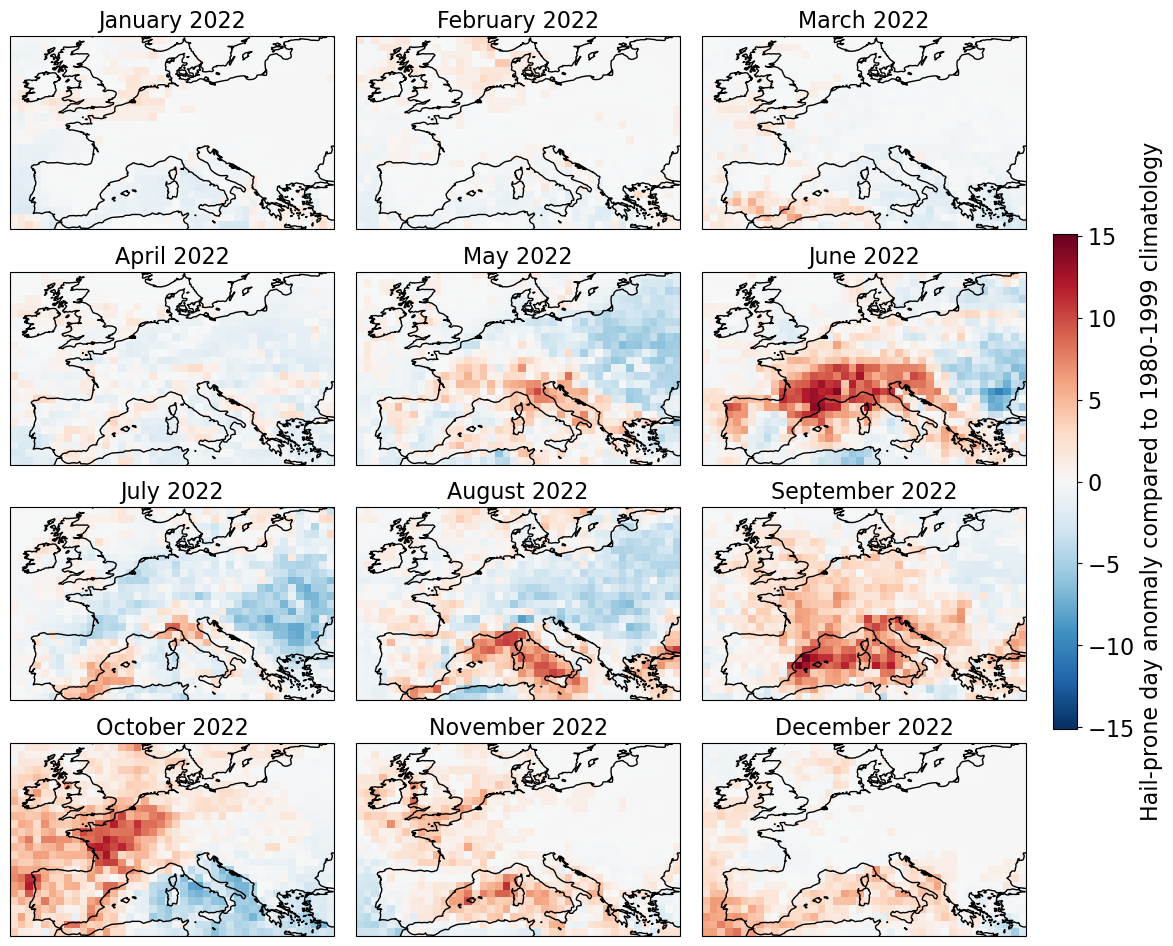

In [28]:
fh.plot_era5_anomalies(anoms=anoms, year=2022, lats=slice(35,60), lons=slice(-12,30), 
                      file='results/monthly_anoms_France_2022.pdf')

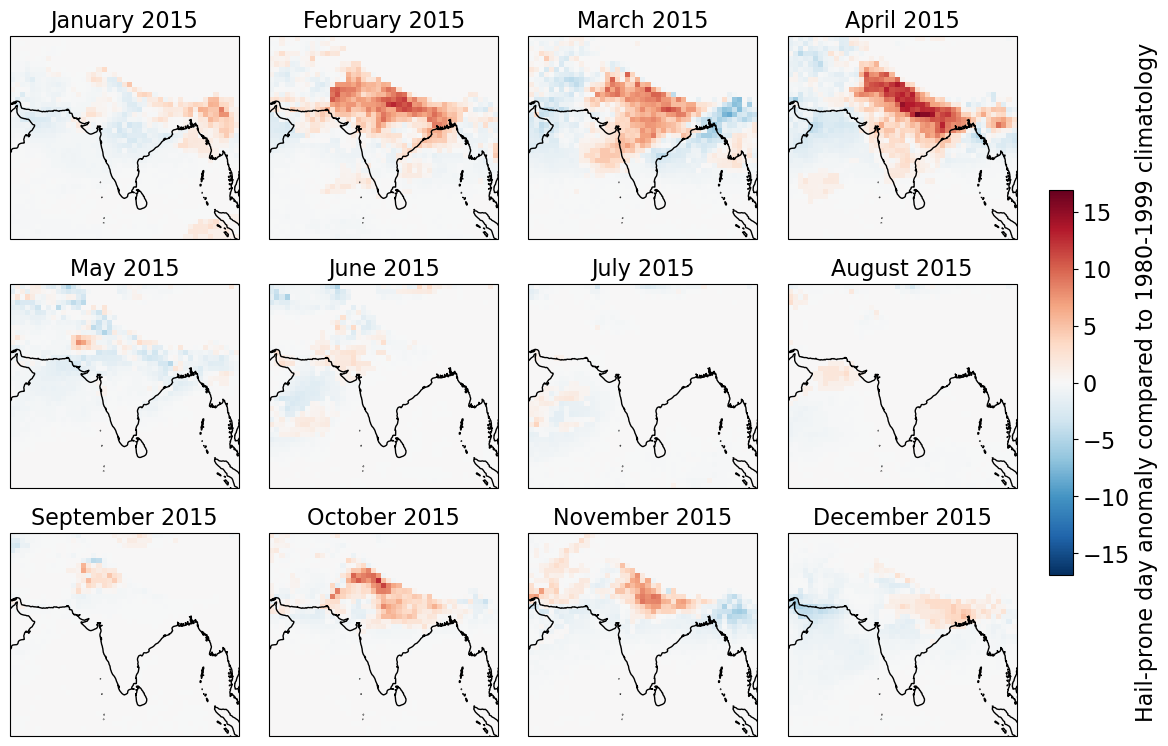

In [29]:
fh.plot_era5_anomalies(anoms=anoms, year=2015, lats=slice(0,40), lons=slice(55,100), figsize=(12,7), ncols=4, nrows=3,
                       file='results/monthly_anoms_India_2015.pdf')

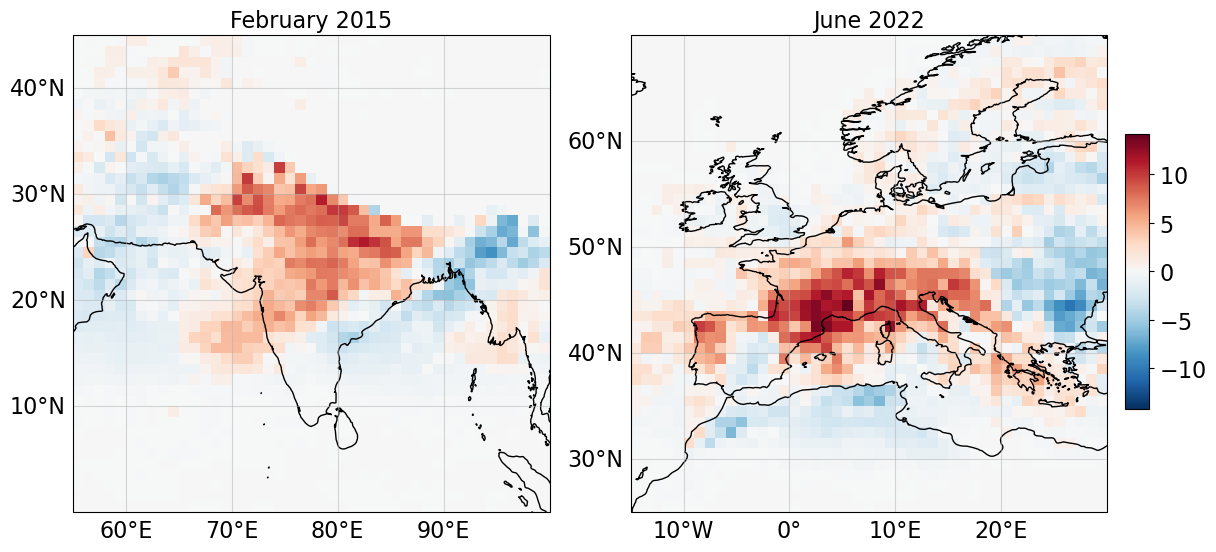

In [30]:
_ = fh.plot_map([anoms.sel(year=2015, month=3, lat=slice(0,45), lon=slice(55,100)).monthly_hail_proxy,
                 anoms.sel(year=2022, month=6, lat=slice(25,70), lon=slice(-15,30)).monthly_hail_proxy], 
                title=['February 2015', 'June 2022'], ncols=2, cmap='RdBu_r', divergent=True, share_scale=True,
                wspace=0.17, file='results/case_anomalies.pdf', figsize=(12,5))

## Differences between epochs

In [ ]:
mean_diffs, mean_diffs_rel, new_areas, sigs = fh.calc_epoch_differences(dat=dat, variables=['annual_hail_proxy', 'seasonal_hail_proxy',
                                                                                            'seasonal_mean_mixed_100_cape',
                                                                                            'seasonal_mean_shear_magnitude',
                                                                                            'seasonal_mean_melting_level',
                                                                                            'seasonal_extreme_mixed_100_cape', 
                                                                                            'seasonal_extreme_shear_magnitude'])

In [ ]:
mm_diffs, mm_sig = fh.multi_model_mean_diffs(diffs=mean_diffs_rel, sigs=sigs)

### Differences in hail-prone days, by model

In [ ]:
fh.plot_diffs_by_epoch(dat=mean_diffs_rel, models=dat.model[0:4].values, var='annual_hail_proxy', 
                       scale_label='Difference in annual hail-prone days [%]',
                       file='results/hail_diffs_by_model_1.pdf')

In [ ]:
fh.plot_diffs_by_epoch(dat=mean_diffs_rel, models=dat.model[4:8].values, var='annual_hail_proxy',
                       scale_label='Difference in annual hail-prone days [%]',
                       file='results/hail_diffs_by_model_2.pdf')

Differences by season for 2C warming:

In [ ]:
fh.plot_mean_diffs_for_epoch(diffs=mm_diffs, sigs=mm_sig, variable='seasonal_hail_proxy', 
                             scale_label='Diff. in annual hail-prone days [%]', epoch='2C', 
                             file='results/hail_changes_by_season_2C.pdf')

Differences by season for 3C warming:

In [ ]:
fh.plot_mean_diffs_for_epoch(diffs=mm_diffs, sigs=mm_sig, variable='seasonal_hail_proxy', 
                             scale_label='Diff. in annual hail-prone days [%]', epoch='3C', 
                             file='results/hail_changes_by_season_3C.pdf')

Differences for DJF only:

In [ ]:
fh.plot_mean_diffs_for_season(diffs=mm_diffs, sigs=mm_sig, variable='seasonal_hail_proxy', 
                              scale_label='Diff. in annual hail-prone days [%]', season='DJF', 
                              file='results/hail_changes_by_epoch_DJF.pdf', figsize=(12,11.5))

Differences for JJA only:

In [ ]:
fh.plot_mean_diffs_for_season(diffs=mm_diffs, sigs=mm_sig, variable='seasonal_hail_proxy', 
                              scale_label='Diff. in annual hail-prone days [%]', season='JJA', 
                              file='results/hail_changes_by_epoch_JJA.pdf', figsize=(12,11.5))

In [ ]:
fh.plot_ing_changes(diffs=mm_diffs, sigs=mm_sig, epoch='2C', file='results/ingredient_changes_2C',
                    variables={'seasonal_extreme_mixed_100_cape': '99% CAPE',
                               'seasonal_mean_mixed_100_cape': 'Mean CAPE',
                               'seasonal_extreme_shear_magnitude': '99% S06',
                               'seasonal_mean_shear_magnitude': 'Mean S06',
                               'seasonal_mean_melting_level': 'Mean MLH'})

In [ ]:
fh.plot_ing_changes(diffs=mm_diffs, sigs=mm_sig, epoch='3C', file='results/ingredient_changes_3C',
                    variables={'seasonal_extreme_mixed_100_cape': '99% CAPE',
                               'seasonal_mean_mixed_100_cape': 'Mean CAPE',
                               'seasonal_extreme_shear_magnitude': '99% S06',
                               'seasonal_mean_shear_magnitude': 'Mean S06',
                               'seasonal_mean_melting_level': 'Mean MLH'})

## Changes in risk during crop growing periods

In [49]:
crop_periods_file = '/g/data/up6/tr2908/future_hail_global/MIRCA2000/growing_periods_listed/CELL_SPECIFIC_CROPPING_CALENDARS_30MN.TXT.gz'

crop_codes = {1: 'Wheat',
              2: 'Maize',
              3: 'Rice',
              4: 'Barley',
              5: 'Rye',
              6: 'Millet',
              7: 'Sorghum',
              8: 'Soybeans',
              9: 'Sunflower', 
              10: 'Potatoes', 
              11: 'Cassava',
              12: 'Sugar cane',
              13: 'Sugar beet',
              14: 'Oil palm', 
              15: 'Rapeseed / Canola',
              16: 'Groundnuts / Peanuts',
              17: 'Pulses',
              18: 'Citrus',
              19: 'Date palm',
              20: 'Grapes / Vine',
              21: 'Cotton',
              22: 'Cocoa',
              23: 'Coffee',
              24: 'Others perennial',
              25: 'Fodder grasses',
              26: 'Others annual'}

In [27]:
crop_periods = pd.read_csv(crop_periods_file, sep='\t')

In [43]:

# Irrigated crops have crop number from 1-26. 
# Rain-fed crops have crop number from 27-52.

crop_periods['crop_type'] = str(np.nan)
crop_periods['crop_name'] = np.nan
crop_periods.loc[crop_periods.crop <= 26, 'crop_type'] = 'Irrigated'
crop_periods.loc[crop_periods.crop >= 27, 'crop_type'] = 'Rainfed'
crop_periods['crop_name'] = crop_periods.crop % 26
crop_periods.loc[crop_periods.crop_name == 0, 'crop_name'] = 26

In [50]:
crop_periods.crop_name = [crop_codes[x] for x in crop_periods.crop_name]

In [51]:
crop_periods

,cell_ID,row,column,lat,lon,crop,subcrop,area,start,end,crop_type,crop_name
0,28484,40,404,70.25,21.75,10,1,0.038939,5,10,Irrigated,Potatoes
1,28484,40,404,70.25,21.75,24,1,0.039185,1,12,Irrigated,Others perennial
2,28484,40,404,70.25,21.75,52,1,0.438755,5,9,Rainfed,Others annual
3,28486,40,406,70.25,22.75,10,1,0.270980,5,10,Irrigated,Potatoes
4,28486,40,406,70.25,22.75,24,1,0.272696,1,12,Irrigated,Others perennial
...,...,...,...,...,...,...,...,...,...,...,...,...
879239,209744,292,224,-55.75,-68.25,30,1,0.011054,8,1,Rainfed,Barley
879240,209744,292,224,-55.75,-68.25,31,1,0.003401,8,1,Rainfed,Rye
879241,209744,292,224,-55.75,-68.25,36,1,0.159642,11,3,Rainfed,Potatoes
879242,209744,292,224,-55.75,-68.25,46,1,0.007773,1,12,Rainfed,Grapes / Vine


In [52]:
crop_periods.subcrop.max()

9

In [55]:
crop_periods.loc[crop_periods.crop_name == 'Grapes / Vine']

,cell_ID,row,column,lat,lon,crop,subcrop,area,start,end,crop_type,crop_name
450,36441,51,441,64.75,40.25,46,1,0.199877,1,12,Rainfed,Grapes / Vine
1207,38604,54,444,63.25,41.75,46,1,0.042630,1,12,Rainfed,Grapes / Vine
1221,38605,54,445,63.25,42.25,46,1,0.812692,1,12,Rainfed,Grapes / Vine
1619,39303,55,423,62.75,31.25,46,1,0.047162,1,12,Rainfed,Grapes / Vine
1633,39311,55,431,62.75,35.25,46,1,0.385906,1,12,Rainfed,Grapes / Vine
...,...,...,...,...,...,...,...,...,...,...,...,...
879196,209021,291,221,-55.25,-69.75,46,1,0.274579,1,12,Rainfed,Grapes / Vine
879208,209022,291,222,-55.25,-69.25,46,1,0.357168,1,12,Rainfed,Grapes / Vine
879220,209023,291,223,-55.25,-68.75,46,1,0.302483,1,12,Rainfed,Grapes / Vine
879233,209024,291,224,-55.25,-68.25,46,1,0.330709,1,12,Rainfed,Grapes / Vine


In [60]:
dat['month'] = dat.

<xarray.Dataset>
Dimensions:                                  (model: 8, epoch: 3, year_num: 20,
                                              season: 4, lat: 180, lon: 360)
Coordinates:
  * epoch                                    (epoch) object '2C' ... 'histori...
  * season                                   (season) object 'DJF' ... 'SON'
  * year_num                                 (year_num) int64 1 2 3 ... 18 19 20
  * lat                                      (lat) float64 -89.5 -88.5 ... 89.5
  * lon                                      (lon) float64 -179.5 ... 179.5
  * model                                    (model) <U13 'CMCC-CM2-SR5' ... ...
Data variables: (12/32)
    seasonal_hail_proxy                      (model, epoch, year_num, season, lat, lon) float64 dask.array<chunksize=(1, 1, 10, 2, 90, 180), meta=np.ndarray>
    seasonal_hail_proxy_noconds              (model, epoch, year_num, season, lat, lon) float64 dask.array<chunksize=(1, 1, 10, 2, 90, 180), meta=np.ndarray>
    seasonal_mean_mixed_100_cape             (model, epoch, year_num, season, lat, lon) float64 dask.array<chunksize=(1, 1, 10, 2, 90, 180), meta=np.ndarray>
    seasonal_mean_mixed_100_cin              (model, epoch, year_num, season, lat, lon) float64 dask.array<chunksize=(1, 1, 10, 2, 90, 180), meta=np.ndarray>
    seasonal_mean_mixed_100_lifted_index     (model, epoch, year_num, season, lat, lon) float64 dask.array<chunksize=(1, 1, 10, 2, 90, 180), meta=np.ndarray>
    seasonal_mean_lapse_rate_700_500         (model, epoch, year_num, season, lat, lon) float64 dask.array<chunksize=(1, 1, 10, 2, 90, 180), meta=np.ndarray>
    ...                                       ...
    annual_extreme_mixed_100_lifted_index    (model, epoch, year_num, lat, lon) float64 dask.array<chunksize=(1, 1, 20, 180, 360), meta=np.ndarray>
    annual_extreme_lapse_rate_700_500        (model, epoch, year_num, lat, lon) float64 dask.array<chunksize=(1, 1, 20, 180, 360), meta=np.ndarray>
    annual_extreme_mixed_100_cape            (model, epoch, year_num, lat, lon) float64 dask.array<chunksize=(1, 1, 20, 180, 360), meta=np.ndarray>
    annual_extreme_temp_500                  (model, epoch, year_num, lat, lon) float64 dask.array<chunksize=(1, 1, 20, 180, 360), meta=np.ndarray>
    annual_extreme_melting_level             (model, epoch, year_num, lat, lon) float64 dask.array<chunksize=(1, 1, 20, 180, 360), meta=np.ndarray>
    annual_extreme_shear_magnitude           (model, epoch, year_num, lat, lon) float64 dask.array<chunksize=(1, 1, 20, 180, 360), meta=np.ndarray>
Attributes:
    history:  Regridded to 1 x 1 degree grid using xESMF.